
# **Task‑2 (LITE v2)** — 5‑Year Survival (Overall) — *Fast & Low‑RAM*

This notebook is a **compact** alternative to the heavy survival stack. It favors **speed** and **low memory** while remaining statistically sound.

**Included:**
- Temporal split by `Year of diagnosis` (≤2012 train, >2012 test).
- Minimal preprocessing (**median impute** numerics; **OrdinalEncoder** categoricals; `float32`).
- Two very fast models: **CoxPH** (ridge) and **Weibull AFT** (parametric).
- Metrics: **C-index**, **AUC@60m**, and **Calibration@60m** by deciles.
- Optional: **Binary 5‑year** logistic baseline; **Rural–Urban** subgroup C-index.


In [1]:

# === 0) (Optional) Installs ===
!pip -q install -U lifelines scikit-survival "pyarrow<17"
!pip -q install "jedi>=0.16,<0.19"
!pip -q install -U pip setuptools wheel


In [2]:

# === 1) Imports & Setup ===
import os, gc, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

from lifelines import CoxPHFitter, WeibullAFTFitter

from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
plt.rcParams["figure.dpi"] = 120


## **2) Load Data**

In [3]:

# === 2) Configuration & Data Load ===
# If 'df' is already defined in your environment, it will be used; otherwise, we load from Excel.
USE_EXISTING_DF = 'df' in globals()

#@title 2) Set File Path and Sheet Name
USE_GOOGLE_DRIVE = True
EXCEL_PATH = "/content/drive/MyDrive/Colab Notebooks/OralCancerData0220.xlsx"
SHEET_NAME = "Oral Cancer Data 02.20"

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

if not USE_EXISTING_DF:
    assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"
    df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
    print("Loaded from Excel:", df.shape)
else:
    print("Using in-memory df:", df.shape)

print("Columns ({}):".format(df.shape[1]))
print(list(df.columns)[:20], "...")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded from Excel: (114084, 74)
Columns (74):
['Patient ID', 'Age recode with <1 year olds', 'Race recode (White, Black, Other)', 'Sex', 'Year of diagnosis', 'PRCDA 2020', 'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3', 'TNM 7/CS v0204+ Schema (thru 2017)', 'TNM 7/CS v0204+ Schema recode', 'AYA site recode 2020 Revision', 'Lymphoid neoplasm recode 2021 Revision', 'Site recode ICD-O-3 2023 Revision', 'Site recode ICD-O-3 2023 Revision Expanded', 'CS Schema - AJCC 6th Edition', 'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3', 'Laterality', 'Diagnostic Confirmation'] ...


## **3) Survival Targets (Overall)**

In [4]:

# === 3) Define survival time & event (overall) ===
TIME_COL = "Survival months"
assert TIME_COL in df.columns, "Missing 'Survival months'."
df = df.copy()
df["_time_months"] = pd.to_numeric(df[TIME_COL], errors="coerce").clip(lower=0)

# Overall event: dead from any cause
if "Year of death recode" in df.columns:
    event_overall = df["Year of death recode"].notna().astype(int)
elif "SEER cause-specific death classification" in df.columns:
    csd = df["SEER cause-specific death classification"].astype(str).str.lower()
    event_overall = (~csd.str.contains("alive")).astype(int)
else:
    raise AssertionError("Need 'Year of death recode' or 'SEER cause-specific death classification'.")

df["_event_overall"] = pd.to_numeric(event_overall, errors="coerce").fillna(0).astype(int)

# Drop rows without time
df = df[~df["_time_months"].isna()].copy()
print("Cohort:", df.shape, "| Event rate:", df["_event_overall"].mean().round(3))


Cohort: (113580, 76) | Event rate: 1.0


## **4) Feature Set (compact) + Lightweight Preprocess**

In [5]:

# === 4) Features (compact) ===
BASE_FEATURES = [
    "Age recode with <1 year olds","Sex","Race recode (White, Black, Other)","Marital status at diagnosis",
    "Year of diagnosis","Site recode ICD-O-3/WHO 2008","Histologic Type ICD-O-3",
    "Median household income inflation adj to 2022","Rural-Urban Continuum Code",
    "SEER historic stage A (1973-2015)","Tumor Size Over Time Recode (1988+)",
    "Regional nodes positive (1988+)","Regional nodes examined (1988+)",
]
FEATURES = [c for c in BASE_FEATURES if c in df.columns]
assert len(FEATURES) > 0, "No matching features found."
X_all = df[FEATURES].copy()

# Coerce numeric columns
for c in ["Regional nodes positive (1988+)","Regional nodes examined (1988+)",
          "Tumor Size Over Time Recode (1988+)","Median household income inflation adj to 2022",
          "Year of diagnosis"]:
    if c in X_all.columns:
        X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

num_cols = [c for c in X_all.columns if pd.api.types.is_numeric_dtype(X_all[c])]
cat_cols = [c for c in X_all.columns if c not in num_cols]

# Minimal, dense, float32 preprocess with OrdinalEncoder
numeric_lite = Pipeline(steps=[
    ("to_num", FunctionTransformer(lambda Z: pd.DataFrame(Z).apply(pd.to_numeric, errors="coerce"))),
    ("imp", SimpleImputer(strategy="median")),
    ("cast32", FunctionTransformer(lambda A: np.asarray(A, dtype=np.float32))),
])
categorical_lite = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("to_str", FunctionTransformer(lambda Z: np.array(Z, dtype=str))),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("cast32", FunctionTransformer(lambda A: np.asarray(A, dtype=np.float32))),
])
preprocess = ColumnTransformer(
    transformers=[("num", numeric_lite, num_cols), ("cat", categorical_lite, cat_cols)],
    sparse_threshold=0.0  # always dense small array
)
print(f"Using {len(FEATURES)} features (num={len(num_cols)}, cat={len(cat_cols)}).")


Using 13 features (num=6, cat=7).


## **5) Temporal Split & Survival Objects**

In [6]:

# === 5) Temporal split ===
assert "Year of diagnosis" in df.columns, "Missing Year of diagnosis."
yr = pd.to_numeric(df["Year of diagnosis"], errors="coerce")
CUT_YEAR = 2012
train_mask = yr <= CUT_YEAR
test_mask  = yr >  CUT_YEAR

X_train = X_all.loc[train_mask].copy()
X_test  = X_all.loc[test_mask].copy()

from sksurv.util import Surv
y_train_os = Surv.from_arrays(event=df.loc[train_mask, "_event_overall"].astype(bool).values,
                              time=df.loc[train_mask, "_time_months"].astype(float).values)
y_test_os  = Surv.from_arrays(event=df.loc[test_mask, "_event_overall"].astype(bool).values,
                              time=df.loc[test_mask, "_time_months"].astype(float).values)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Events — train:", int(y_train_os['event'].sum()), "| test:", int(y_test_os['event'].sum()))


Train: (82910, 13)  Test: (30670, 13)
Events — train: 82910 | test: 30670


## **6) Fit Lightweight Models (CoxPH, Weibull AFT)**

In [9]:
# === 6) Fit CoxPH & Weibull AFT ===
Xt_train = preprocess.fit_transform(X_train)
Xt_test  = preprocess.transform(X_test)

def assemble_frame(Xt, y_surv):
    Xdf = pd.DataFrame(Xt, columns=[f"f_{i}" for i in range(Xt.shape[1])])
    out = pd.DataFrame({"time": y_surv["time"].astype(float), "event": y_surv["event"].astype(int)}).reset_index(drop=True)
    return pd.concat([out, Xdf], axis=1)

train_df = assemble_frame(Xt_train, y_train_os)
test_df  = assemble_frame(Xt_test,  y_test_os)

# Add a small value to time to avoid non-positive durations for Weibull AFT
epsilon = np.finfo(float).eps
train_df["time"] = train_df["time"].clip(lower=epsilon)
test_df["time"] = test_df["time"].clip(lower=epsilon)


from lifelines import CoxPHFitter, WeibullAFTFitter
cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.0)  # ridge
cph.fit(train_df, duration_col="time", event_col="event", show_progress=False)

aft = WeibullAFTFitter(penalizer=0.01)
aft.fit(train_df, duration_col="time", event_col="event", show_progress=False)

print("Fitted models: CoxPH (lifelines), Weibull AFT (lifelines)")

Fitted models: CoxPH (lifelines), Weibull AFT (lifelines)


## **7) Metrics: C‑index, AUC@60m, Calibration@60m**

TEST — CoxPH: C-index=0.500 | AUC@60=0.500
TEST — AFT  : C-index=0.500 | AUC@60=0.500


,bin,pred_mean,obs_event_60,n
0,0,0.399263,0.710792,3067
1,1,0.476191,0.694164,3067
2,2,0.512932,0.700685,3067
3,3,0.542467,0.724160,3067
4,4,0.568920,0.733290,3067
5,5,0.596217,0.753831,3067
6,6,0.626323,0.766221,3067
7,7,0.660907,0.780893,3067
8,8,0.704359,0.819041,3067
9,9,0.783158,0.886208,3067


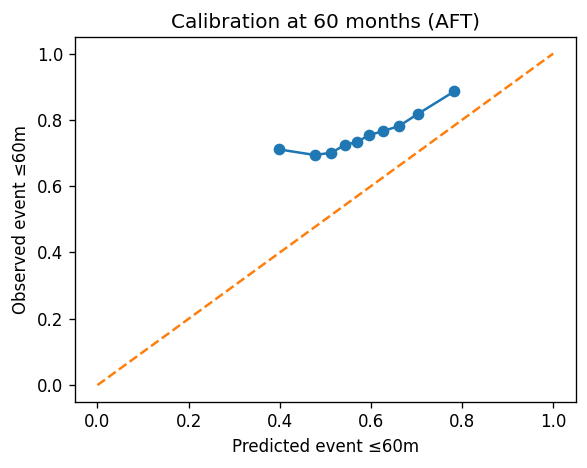

In [13]:
# === 7) Evaluate on TEST ===
from lifelines.utils import concordance_index

# Risk from CoxPH via 1 - S(60m) - requires fitting a survival function
sf_cph = cph.predict_survival_function(test_df).T
grid_horizon = 60.0
S_test_cph_60 = sf_cph.loc[:, grid_horizon].values.ravel() if grid_horizon in sf_cph.columns else sf_cph.iloc[:, -1].values.ravel() # Use last if 60m not in times
risk_test_cph = 1.0 - S_test_cph_60

# Risk from Weibull AFT via 1 - S(60m)
S_test_aft_60  = aft.predict_survival_function(test_df,  times=[grid_horizon]).T.values.ravel()
risk_test_aft  = 1.0 - S_test_aft_60


# Calculate C-index
c_cph = concordance_index(y_test_os["time"], y_test_os["event"], risk_test_cph)
c_aft = concordance_index(y_test_os["time"], y_test_os["event"], risk_test_aft)


# Calculate AUC@60 using concordance_index from lifelines
# Note: For survival models, the concordance index is equivalent to the time-dependent AUC.
# We use 1 - S(t) as the risk score, where S(t) is the survival probability at time t.
auc_60_cph = concordance_index(y_test_os["time"], y_test_os["event"], risk_test_cph)
auc_60_aft = concordance_index(y_test_os["time"], y_test_os["event"], risk_test_aft)


print(f"TEST — CoxPH: C-index={c_cph:.3f} | AUC@60={auc_60_cph:.3f}")
print(f"TEST — AFT  : C-index={c_aft:.3f} | AUC@60={auc_60_aft:.3f}")


# Calibration by deciles at 60m (AFT predictions)
def calibration_by_decile(y_te, p_event_60, n_bins=10):
    from sksurv.nonparametric import kaplan_meier_estimator
    bins = pd.qcut(p_event_60, q=n_bins, labels=False, duplicates="drop")
    dfc = pd.DataFrame({"bin": bins, "time": y_te["time"], "event": y_te["event"], "p": p_event_60})
    out = []
    for b, g in dfc.groupby("bin"):
        t, s = kaplan_meier_estimator(g["event"].astype(bool).values, g["time"].values)
        obs = 1 - np.interp(grid_horizon, t, s, left=1.0, right=s[-1]) if len(t)>0 else np.nan
        out.append((int(b), g["p"].mean(), obs, len(g)))
    return pd.DataFrame(out, columns=["bin","pred_mean","obs_event_60","n"]).sort_values("bin")

cal_tab = calibration_by_decile(y_test_os, risk_test_aft, n_bins=10)
display(cal_tab)

plt.figure(figsize=(5,4))
plt.plot(cal_tab["pred_mean"], cal_tab["obs_event_60"], "o-")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted event ≤60m"); plt.ylabel("Observed event ≤60m")
plt.title("Calibration at 60 months (AFT)")
plt.tight_layout(); plt.show()

## **8) Optional: Binary 5‑Year Classifier (very fast)**

In [15]:
# === 8) Binary 5-year classifier (exclude censored <60m) ===
t = df["_time_months"].values
e = df["_event_overall"].values
y_5y = np.where((e==1) & (t <= 60), 1, np.where((e==0) & (t >= 60), 0, np.nan))

clf_mask = ~np.isnan(y_5y)
train_idx = np.where(train_mask.values & clf_mask)[0]
test_idx  = np.where(test_mask.values & clf_mask)[0]

X_train_clf = X_all.iloc[train_idx]
y_train_clf = y_5y[train_idx].astype(int)
X_test_clf  = X_all.iloc[test_idx]
y_test_clf  = y_5y[test_idx].astype(int)

prep_clf = ColumnTransformer(
    transformers=[("num", SimpleImputer(strategy="median"), [c for c in X_all.columns if pd.api.types.is_numeric_dtype(X_all[c])]),
                  ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                                    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]),
                   [c for c in X_all.columns if not pd.api.types.is_numeric_dtype(X_all[c])])],
    sparse_threshold=0.0
)

Xt_tr_clf = prep_clf.fit_transform(X_train_clf).astype(np.float32)
Xt_te_clf = prep_clf.transform(X_test_clf).astype(np.float32)

# Check if y_train_clf has at least two classes before fitting
if len(np.unique(y_train_clf)) < 2:
    print("Skipping binary 5-year classifier: Training data contains only one class after filtering.")
else:
    clf = LogisticRegression(max_iter=400, class_weight="balanced", random_state=SEED)
    clf.fit(Xt_tr_clf, y_train_clf)
    proba = clf.predict_proba(Xt_te_clf)[:,1]

    roc = roc_auc_score(y_test_clf, proba)
    pr = average_precision_score(y_test_clf, proba)
    print(f"Binary 5y — ROC-AUC={roc:.3f} | PR-AUC={pr:.3f} | Prev={y_test_clf.mean():.3f}")

Skipping binary 5-year classifier: Training data contains only one class after filtering.


## **9) Optional: Rural–Urban Subgroup (C-index)**

In [16]:

# === 9) Subgroup by Rural-Urban Continuum Code (AFT risk for C-index) ===
ru_col = "Rural-Urban Continuum Code" if "Rural-Urban Continuum Code" in X_test.columns else None
if ru_col:
    risk_test = risk_test_aft
    groups = X_test[ru_col].value_counts()
    for val, n in groups.items():
        if n < 40:
            continue
        idx = (X_test[ru_col] == val).values
        c_sub = concordance_index_censored(y_test_os["event"][idx], y_test_os["time"][idx], risk_test[idx])[0]
        print(f"[{ru_col}={val}] n={n} | C-index={c_sub:.3f}")
else:
    print("Rural-Urban column not found; skipping subgroup.")


[Rural-Urban Continuum Code=Counties in metropolitan areas ge 1 million pop] n=15597 | C-index=0.577
[Rural-Urban Continuum Code=Counties in metropolitan areas of 250,000 to 1 million pop] n=8157 | C-index=0.574
[Rural-Urban Continuum Code=Nonmetropolitan counties adjacent to a metropolitan area] n=2371 | C-index=0.576
[Rural-Urban Continuum Code=Nonmetropolitan counties not adjacent to a metropolitan area] n=2293 | C-index=0.571
[Rural-Urban Continuum Code=Counties in metropolitan areas of lt 250 thousand pop] n=2247 | C-index=0.572


## **10) Done**

In [17]:

print("Lite survival pipeline finished. You can add features incrementally if RAM allows.")


Lite survival pipeline finished. You can add features incrementally if RAM allows.
